## Unused Dramatic Characters and Discontinuous Scenes
Given the current markup / data on play summaries (for pdf files), we  could generate two features that were briefly mentioned by Iarkho. So far, we had no understanding how these features evolved over time and whether they could differentiate literary periods.
 
The two features:
- **The Coefficient of Unused Dramatic Characters** that measures the proportion of the dramatic characters who do not speak in a scene. This was a distinctive feature for tragedy (Iarkho 2006, 448-51)
- **The Percentage of Discontinuous Scenes**, i.e., the scenes where no dramatic character from the preceding scene re-appears on stage in the following scene (Iarkho 2006, 472-4). 
    - For example, scene two is a discontinuous scene since it does not share a single dramatic character with scene one: Scene 1. FILIPIN, ANGELIQUE. Scene 2. ORONTE. 

We will explore the following issues:
1. Are these features normally distributed?
2. Can they be used to differentiate the three periods which we have previously discovered?
3. Visualizations and summary statistics for each feature.

In [1]:
import pandas as pd
import numpy as np
import json
from os import listdir
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import shapiro

### The Coefficient of Unused Dramatic Characters

When we were creating features for the plays, we calculated feature *the average percentage of non-speaking dramatic characters*. This feature was calculated in the following way: for each scene, we calculted the percentage of the dramatic characters who do not speak in the particular scene; finally, we took the average across all scenes.

Upon re-reading Iarkho's article *Corneille's Comedies and Tragedies*, we realized that he used a slightly different feature called **the coefficient of unused dramatic characters**. Iarkho gave the following example of its calculation for the tragedy *Cinna*.

In [2]:
cinna = pd.DataFrame([1, 2, 3, 4, 4, 3, 2, 2, 2, 1, 3, 2, 4, 2, 1, 2, 1, 2, 3, 1, 2, 5, 6]).T
cinna.index = ['present']

In [3]:
cinna = pd.concat([pd.DataFrame([1, 2, 3, 4, 4, 3, 2, 2, 2, 1, 3, 2, 4, 2, 1, 2, 1, 2, 3, 1, 2, 5, 6]).T, 
        pd.DataFrame([0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]).T])
cinna.columns = [i+1 for i in cinna.columns]
cinna.index = ['present', 'non_speaking']

In [4]:
cinna['total'] = cinna.sum(axis=1)

In [5]:
pd.set_option('display.max_columns', 25)
cinna

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,total
present,1,2,3,4,4,3,2,2,2,1,3,2,4,2,1,2,1,2,3,1,2,5,6,58
non_speaking,0,0,1,1,3,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,10


In [6]:
print('The coefficient of unused dramatic characters: {}%'.format(
        round((10 / 58) * 100, 1)))

The coefficient of unused dramatic characters: 17.2%


Because the process of feature calculation differs slightly from our calculation of the average percentage of non-speaking dramatic characters, we had to re-calculate this feature.

In [7]:
def coefficient_unused_dramatic_characters(data):
    total_present = 0
    total_non_speakers = 0
    for act in data['play_summary'].keys():
        for scene in data['play_summary'][act].keys():
            # identify the raw number of non-speaking dramatic characters
            num_non_speakers = len([item for item in data['play_summary'][act][scene].items() 
                                if (item[1] == 0  or item[1] == 'non_speaking') and item[0] not in ['num_utterances',
                                                                   'num_speakers',
                                                                   'perc_non_speakers']])
            total_non_speakers += num_non_speakers
            # calculate the total number of dramatic characters
            total_present += (data['play_summary'][act][scene]['num_speakers'] + num_non_speakers)
    coefficient_unused = (total_non_speakers / total_present ) * 100        
    
    return coefficient_unused

In [8]:
def get_data(input_directory):
    all_files = [f for f in listdir(input_directory) if f.count('.json') > 0]
    dfs = []
    for file in all_files:
        with open(input_directory + '/' + file) as json_file:
            data = json.load(json_file)
            not_used = coefficient_unused_dramatic_characters(data)
            df = pd.DataFrame([not_used], columns=['coefficient_unused'], index=[file.replace('.json','')])
            dfs.append(df)
            
    features_df = pd.concat(dfs, axis=0, sort=False).round(2)
    
    return features_df

In [9]:
# set the boundaries as we determined based on our analysis of a 10% sample
def determine_period(row):
    if row <= 1695:
        period = 1
    elif row >= 1696 and row <= 1795:
        period = 2
    else:
        period = 3
    
    return period

In [10]:
def run_tests(test, feature):
    """
    The function allows us to run a statistical test of our choice on the adjacent periods.
    Params:
        test - a test of our choice, e.g., mannwhitneyu.
        feature - str, name of the feature we want to test on.
    Returns:
        no retun, prints the result of each test
    """
    result_one = test(period_one[feature], 
             period_two[feature]) 
    print('Period one and two:', '\n', feature, result_one)
    
    result_two = test(period_two[feature], 
             period_three[feature]) 
    print('Period two and three:', '\n', feature, result_two)


In [11]:
def summary(feature):
    mean = feature.mean()
    std = feature.std()
    median = feature.median()
    
    return mean, std, median

In [12]:
def make_plot(feature, title):
    mean, std, median = summary(feature)
    plt.figure(figsize=(10, 7))
    plt.title(title, fontsize=17)
    sns.distplot(feature, kde=False)
    mean_line = plt.axvline(mean, 
                            color='black',
                            linestyle='solid', 
                            linewidth=2); M1 = 'Mean';
    median_line = plt.axvline(median, 
                               color='green',linestyle='dashdot', 
                               linewidth=2); M2='Median'
    std_line = plt.axvline(mean + std, 
                           color='black',
                           linestyle='dashed', 
                           linewidth=2); M3 = 'Standard deviation';
    plt.axvline(mean - std, 
                color='black',
                linestyle='dashed', 
                linewidth=2)

    plt.legend([mean_line, median_line, std_line], [M1, M2, M3])
    plt.show()

In [13]:
# read the data
data = pd.read_csv('../French_Comedies/Data/French_Comedies_Data.csv')

In [14]:
data.shape

(277, 25)

In [15]:
# read the sample data
sample_df = pd.read_csv('../French_Comedies/Data/French_Comedies_Data_Sample.csv')

In [16]:
# exclude the comedies used for the sample analysis
not_sample = data[~data['index'].isin(sample_df['index'])].copy()

In [17]:
not_sample.shape

(248, 25)

In [18]:
not_sample.columns

Index(['index', 'title', 'last_name', 'first_name', 'date',
       'translation/adaptation/contrastive', 'num_acts', 'url',
       'num_present_characters', 'num_scenes_text', 'num_scenes_iarkho',
       'speech_distribution', 'percentage_monologues', 'percentage_duologues',
       'percentage_non_duologues', 'percentage_above_two_speakers',
       'av_percentage_non_speakers', 'sigma_iarkho',
       'number_scenes_with_discontinuous_change_characters',
       'percentage_scenes_with_discontinuous_change_characters',
       'total_utterances', 'num_verse_lines', 'dialogue_vivacity',
       'five_year_intervals', 'decades'],
      dtype='object')

In [19]:
# include only five act comedies and only the comedies that are not translations/adaptations 
original_comedies = not_sample[(not_sample['num_acts'] ==5)&
                               (not_sample['translation/adaptation/contrastive'] == 0)].copy()

In [20]:
original_comedies.head()

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,num_scenes_iarkho,speech_distribution,percentage_monologues,percentage_duologues,percentage_non_duologues,percentage_above_two_speakers,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades
0,F_3,Mélite ou Les fausses lettres,Corneille,Pierre,1629,0,5,http://www.theatre-classique.fr/pages/document...,8,35,39,[[ 1 12]\n [ 2 18]\n [ 3 7]\n [ 4 1]\n [ 5 1]],30.77,46.15,53.85,23.08,0.513,0.906,12,30.769,483.0,1822.0,0.265,1630,1630
1,F_5,La Veuve ou Le Traître trahi,Corneille,Pierre,1633,0,5,http://www.theatre-classique.fr/pages/document...,12,40,45,[[ 1 13]\n [ 2 23]\n [ 3 5]\n [ 4 2]\n [ 5 ...,28.89,51.11,48.89,20.00,3.519,1.062,12,26.667,521.0,2010.0,0.259,1635,1640
4,F_11,La Galerie du Palais,Corneille,Pierre,1634,0,5,http://www.theatre-classique.fr/pages/document...,12,53,53,[[ 1 7]\n [ 2 33]\n [ 3 7]\n [ 4 3]\n [ 5 ...,13.21,62.26,37.74,24.53,0.000,1.148,10,18.868,517.0,1794.0,0.288,1635,1640
5,F_12,La Suivante,Corneille,Pierre,1634,0,5,http://www.theatre-classique.fr/pages/document...,10,47,47,[[ 1 15]\n [ 2 27]\n [ 3 4]\n [ 5 1]],31.91,57.45,42.55,10.64,0.000,0.753,11,23.404,410.0,1700.0,0.241,1635,1640
6,F_7,Les Vendanges de suresnes,du Ryer,Pierre,1635,0,5,http://www.theatre-classique.fr/pages/document...,11,36,39,[[ 1 3]\n [ 2 19]\n [ 3 10]\n [ 4 3]\n [ 5 ...,7.69,48.72,51.28,43.59,1.923,1.476,13,33.333,589.0,1837.0,0.321,1635,1640


In [21]:
original_comedies.shape

(228, 25)

In [22]:
# sort by date
sorted_comedies = original_comedies.sort_values(by='date')

In [23]:
sorted_comedies.columns

Index(['index', 'title', 'last_name', 'first_name', 'date',
       'translation/adaptation/contrastive', 'num_acts', 'url',
       'num_present_characters', 'num_scenes_text', 'num_scenes_iarkho',
       'speech_distribution', 'percentage_monologues', 'percentage_duologues',
       'percentage_non_duologues', 'percentage_above_two_speakers',
       'av_percentage_non_speakers', 'sigma_iarkho',
       'number_scenes_with_discontinuous_change_characters',
       'percentage_scenes_with_discontinuous_change_characters',
       'total_utterances', 'num_verse_lines', 'dialogue_vivacity',
       'five_year_intervals', 'decades'],
      dtype='object')

In [24]:
# create time periods based on our hypothesized periodization
sorted_comedies['period'] = sorted_comedies['date'].apply(determine_period)

In [25]:
# rename column names for clarity
sorted_comedies = sorted_comedies.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                 'percentage_non_duologues': 'percentage_non_dialogues',
                                                  'percentage_above_two_speakers': 'percentage_polylogues',
                                                  'percentage_scenes_with_discontinuous_change_characters': 
                                                  'discontinuous_scenes'})

In [26]:
# calculate the coefficient of non-used dramatic characters
unused_coefficient = get_data('../French_Comedies/Play_Jsons/')
unused_coefficient['index'] = unused_coefficient.index.tolist()
merged_df = sorted_comedies.merge(unused_coefficient, on='index')

### Is The Average Percentage of Non-Speakers Correlated with the Coefficient of Unused Dramatic Characters?

In [27]:
merged_df[['av_percentage_non_speakers', 'coefficient_unused']].corr()

,av_percentage_non_speakers,coefficient_unused
av_percentage_non_speakers,1.000000,0.936264
coefficient_unused,0.936264,1.000000


There is a very high positive correlation between our original feature average percentage of non-speaking characters and the coefficient of unused characters (0.93). However, it still makes sense to use Iarkho's original feature to make the results more comparable.

In [28]:
# define the features we want to analyze
features = ['coefficient_unused',
            'discontinuous_scenes',
            'num_present_characters', 
            'mobility_coefficient',
            'sigma_iarkho',
            'percentage_monologues', 
            'percentage_non_dialogues', 
            'percentage_polylogues']

## Feature Correlations

In [29]:
merged_df[features].corr()[['coefficient_unused',
                            'discontinuous_scenes']].round(2)

,coefficient_unused,discontinuous_scenes
coefficient_unused,1.00,-0.23
discontinuous_scenes,-0.23,1.00
num_present_characters,0.36,0.05
mobility_coefficient,0.30,-0.32
sigma_iarkho,0.13,0.06
percentage_monologues,-0.06,-0.03
percentage_non_dialogues,0.07,-0.13
percentage_polylogues,0.09,-0.07


The coefficient of unused dramatic characters is moderately positively correlated with the mobility coefficient (0.30) and the number of dramatic characters (0.36). The percentage of discontinuous scenes is moderately negatively correlated with the mobility coefficient (-0.32)  and coefficient of unused characters (-0.23).


## Feature Distributions and Normality

In this section we will plot the distribution of each feature and run Shapiro-Wilk test for normality.

### How will we check normality?
For each feature, will run the Shapiro-Wilk test.We will set the significance level at 0.05. If the p-value returned by the test will be below 0.05, we will reject the null hypothesis of the normal distribution of the feature. Otherwise, we will fail to reject the hypothesis.

### The Coefficient of Unused Dramatic Characters

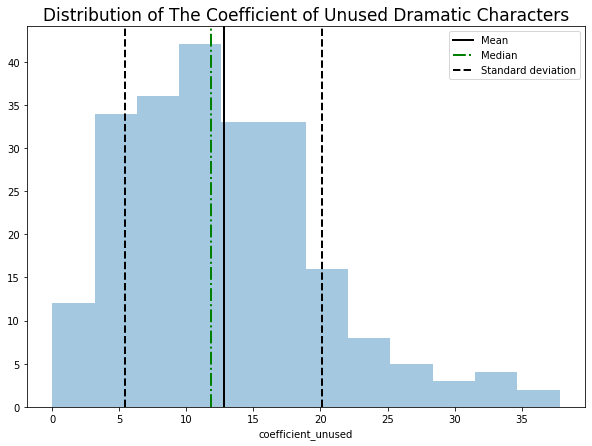

In [30]:
make_plot(merged_df['coefficient_unused'], 
         'Distribution of The Coefficient of Unused Dramatic Characters')

In [31]:
mean, std, median = summary(merged_df['coefficient_unused'])
print('Mean coefficient of unused dramatic characters:', round(mean, 2))
print('Standard deviation of the coefficient of unused dramatic characters:', round(std, 2))
print('Median coefficient of unused dramatic characters:', median)

Mean coefficient of unused dramatic characters: 12.77
Standard deviation of the coefficient of unused dramatic characters: 7.34
Median coefficient of unused dramatic characters: 11.81


### Shapiro-Wilk Normality Test

In [32]:
print('The p-value of the Shapiro-Wilk normality test:', 
      shapiro(merged_df['coefficient_unused'])[1])

The p-value of the Shapiro-Wilk normality test: 1.3412660564426915e-06


The Shapiro-Wilk test showed that the probability that the data is normally distributed is extremely low (p-value is 1.3412660564426915e-06).

### The Percentage of Discontinuous Scenes

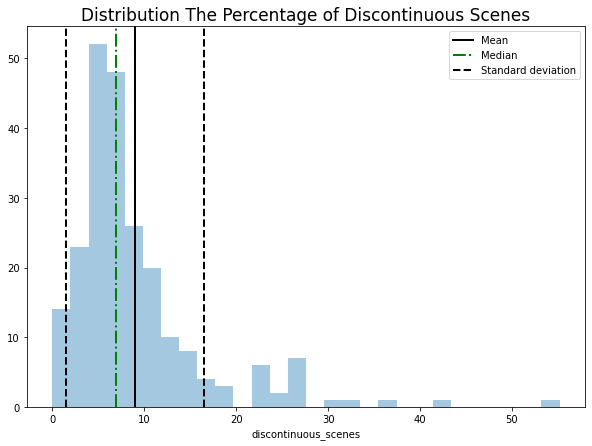

In [33]:
make_plot(merged_df['discontinuous_scenes'], 
         'Distribution The Percentage of Discontinuous Scenes')

In [34]:
mean, std, median = summary(merged_df['discontinuous_scenes'])
print('Mean percentage of discontinuous scenes', round(mean, 2))
print('Standard deviation of the percentage of discontinuous scenes:', round(std, 2))
print('Median percentage of discontinuous scenes:', median)

Mean percentage of discontinuous scenes 8.99
Standard deviation of the percentage of discontinuous scenes: 7.53
Median percentage of discontinuous scenes: 6.897


### Shapiro-Wilk Normality Test

In [35]:
print('The p-value of the Shapiro-Wilk normality test:', 
      shapiro(merged_df['discontinuous_scenes'])[1])


The p-value of the Shapiro-Wilk normality test: 2.1974818941718404e-17


The Shapiro-Wilk normality test shows that the probability of this feature of being normally distributed is extremely low (2.1974818941718404e-17).

## Summary:
Both features are not normally distributed. If we want to perform any statistical testing on these features, non-parametric tests will be more appropriate.

## Can These Features Differentiate Periods?

We have established three periods in the evolution of the French five-act comedy in verse:
- Period one: from 1629 to 1695
- Period two: from 1696 to 1795
- Period three: from 1796 to 1849

However, we have no understanding if the coefficient of unused dramatic characters and the percentage of discontinuous scenes can differentiate literary periods. We will run non-parametric statistical tests to answer this question. Our null hypothesis will be that there is no difference between the distribution of each feature in the three literary periods. Our alternative hypothesis will be that there is a significant difference between the literary periods based on these features. Our significance level will be set at 0.05. We will run Kruskal-Wallis test. If we identify that that there are significant differences between periods, we will follow up with Mann Whitney test to see between which periods these differences occur.

In [36]:
from scipy.stats import kruskal, mannwhitneyu

In [37]:
# define each period
period_one = merged_df[merged_df.period == 1].copy()
period_two = merged_df[merged_df.period == 2].copy()
period_three = merged_df[merged_df.period == 3].copy()

In [38]:
period_one.shape

(83, 27)

In [39]:
period_two.shape

(91, 27)

In [40]:
period_three.shape

(54, 27)

In [41]:
def scatter(df, feature, title, xlabel, text_y):
    sns.jointplot('date', 
               feature,
               data=df, 
               color='b', 
               height=7).plot_joint(
               sns.kdeplot, 
               zorder=0, 
               n_levels=30)
    plt.axvline(1695, color='grey',linestyle='dashed', linewidth=2)
    plt.axvline(1795, color='grey',linestyle='dashed', linewidth=2)
    plt.text(1695.5, text_y, '1695')
    plt.text(1795.5, text_y, '1795')
    plt.title(title, fontsize=20, pad=100)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(xlabel, fontsize=14)

    plt.show()

## Coefficient of Unused Dramatic Characters

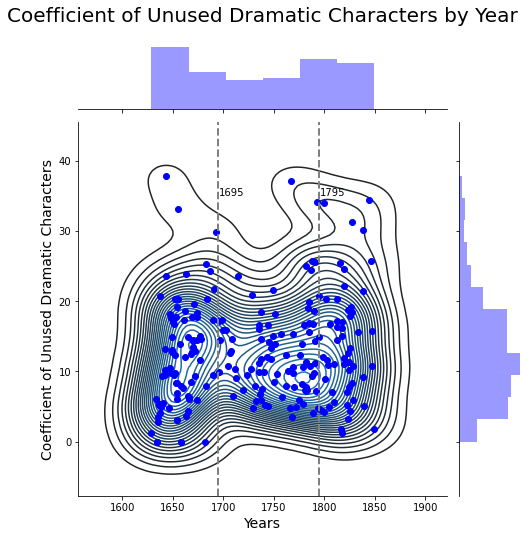

In [42]:
scatter(merged_df, 
        'coefficient_unused', 
        'Coefficient of Unused Dramatic Characters by Year', 
        'Coefficient of Unused Dramatic Characters',
         35)

In [43]:
merged_df.groupby('period').describe().loc[:, 'coefficient_unused'][['mean', 'std', '50%','min', 'max']].round(2)

,mean,std,50%,min,max
period,,,,,
1,12.17,7.73,12.09,0.00,37.83
2,12.75,6.37,11.40,3.49,37.05
3,13.74,8.25,11.94,1.22,34.36


#### The Kruskal-Wallis Test

In [44]:
kruskal(period_one['coefficient_unused'],
        period_two['coefficient_unused'],
        period_three['coefficient_unused'])

KruskalResult(statistic=1.047116575047635, pvalue=0.5924088321957536)

### Summary

The p-value that the coefficient of unused dramatic characters does not differ between the three periods is 0.59. Therefore, we fail to reject the hypothesis of no difference between the periods based on this feature.

So, the feature that, according to Iarkho, is excellent at differentiating tragedies from comedies (Iarkho 2006, 448-51) does not allow us to differentiate comedies of different periods. 

### Side Note

According to Iarkho, the coefficient of unused dramatic characters is always higher in Corneille's tragedy than in his comedy
- periods one and two (1629 to 1636): 7.6% in comedy vs. 24.3% in tragedy.
- period three (1637 to 1643): 11% in comedy vs. 27.6% in tragedy.
- period four (1644 - 1674, for tragedy only): 26%.

The mean coefficient of unused dramatic characters for period one in our corpus is 12.17% (i.e., higher than in Corneille's comedies but still much lower than in Corneille's tragedies).

In fact, all periods in the evolution of comedy have the coefficient of unused dramatic characters below 15%, with the highest value observed in the third period (13.74%).

## The Percentage of Discontinuous Scenes

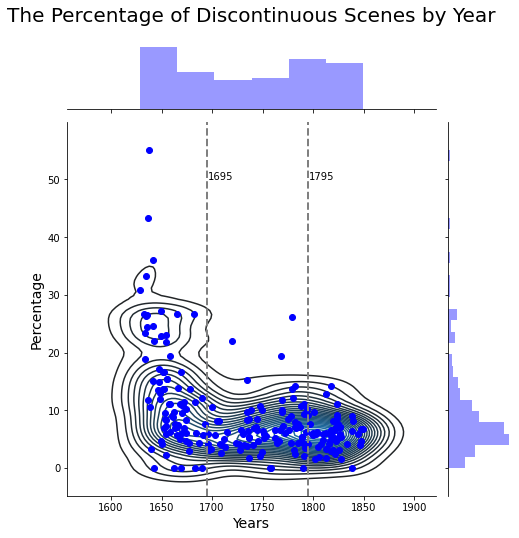

In [45]:
scatter(sorted_comedies, 
        'discontinuous_scenes', 
        'The Percentage of Discontinuous Scenes by Year', 
        'Percentage',
        50)

In [46]:
sorted_comedies.groupby('period').describe().loc[:,
                                                 'discontinuous_scenes'][['mean', 'std', '50%','min', 'max']].round(2)

,mean,std,50%,min,max
period,,,,,
1,13.37,10.08,11.11,0.0,55.17
2,6.88,4.23,6.25,0.0,26.09
3,5.83,2.71,5.88,0.0,14.29


#### The Kruskal-Wallis Test

In [47]:
kruskal(period_one['discontinuous_scenes'],
        period_two['discontinuous_scenes'],
        period_three['discontinuous_scenes'])

KruskalResult(statistic=40.499377824343874, pvalue=1.6057274997763856e-09)

The Kruskal Wallis test showed that there is a significant difference between the periods (p-value is extremely low 1.6057274997763856e-09). Now, we will run the Mann Whitney test to see where the difference occur.

#### The Mann-Whitney U-Test

In [48]:
run_tests(mannwhitneyu, 'discontinuous_scenes')

Period one and two: 
 discontinuous_scenes MannwhitneyuResult(statistic=2024.0, pvalue=6.474224060234932e-08)
Period two and three: 
 discontinuous_scenes MannwhitneyuResult(statistic=2161.5, pvalue=0.11377539053266533)


The percentage of discontinous characters can differentiate between periods one and two: the p-value of them being the same distribution is extremely low (6.474224060234932e-08). However, it does enable us to differentiate periods two and three: the p-value is 0.113, above the 0.05 significance level.

Overall, in period one the mean percentage of discontinuous scenes is the highest (13.37%), it decreases in period two (6.88%) and further drops to 5.83%. In period three, it becomes very common for comedies to have low discontinuity between the scenes. Period one also has the highest maximum percentage of discontinuous scenes out of all periods (55.17%). Standard deviation also decreases from period one through period three (from 10.08 to 4.23, and finally, to 2.71. During period one, there is still quite a lot of variation, but by period three, low discontinuity becomes the rule: there is often at least one dramatic character who stays on stage from the preceding scene.

## Conclusions:
1. While the coefficient of non-used dramatic characters could serve as a basis of differentiating tragedy from comedy, this feature does not enable us to differentiate between different literary periods in the evolution of comedy.
2. The percentage of discontinuous scenes can differentiate periods one and two but not periods two and three. 
3. Over the course of the evolution of the French five-act comedy in verse, the percentage of discontinuous scenes was decreasing. By the third period, low discontinuity in comedy (5.83% with a low standard deviation 2.71) became the norm. Simply put, it would be very frequent for a dramatic characters from a preceeding scene remain on stage.
4. Exploration of the evolution of the percentage of discontinuous scenes in tragedy remains a valuable question that future researchers of drama could explore. It would be insightful to compare the behavior of this feature in tragedy as opposted to comedy.